##  Ⅰ. [감성 분석 + 토픽 모델링] 영화 리뷰 데이터로 감성 예측하기

In [24]:
import warnings
import pandas as pd

warnings.filterwarnings(action = 'ignore') # warning 메시지 표시 안함

### 1)훈련용 데이터 준비하기

In [25]:
# 1. 훈련용 데이터인 ratings_train.txt 파일을 로드

# 아. txt파일도 read_csv로 읽을 수 있네;;..?
nsmc_train_df = pd.read_csv('4.3ref/ratings_train.txt', encoding ='utf8', sep = '\t', engine = 'python')

nsmc_train_df.head()
len(nsmc_train_df) # 150000

150000

In [26]:
nsmc_train_df.info() # 정보확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [27]:
# 2. 결측치 제거
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]

nsmc_train_df['label'].value_counts()
# 0 75170
# 1 74825

label
0    75170
1    74825
Name: count, dtype: int64

In [28]:
# 3. 한글 외의 문자 제거하기
    # * 기법 꼭 기억하기 -> 이렇게 하면 모든 열에서 정규식 표현식 됨
    #  ‘ㄱ’으로 시작하거나 ‘가’부터 ‘힣’까지의 문자를 제외한 나머지는 공백으로 치환
import re
nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2)평가용 데이터 준비하기

In [29]:
nsmc_test_df = pd.read_csv('4.3ref/ratings_test.txt', encoding='utf8', sep='\t', engine='python')
nsmc_test_df.head()

nsmc_test_df.info() # *id가 50000개 non-null, document가 49997이 non-null이면 -> document에서 총 3개가 null이란 뜻ㅇㅇ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [30]:
#document 칼럼이 Null인 샘플 제거
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()]
nsmc_test_df['label'].value_counts() 

nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

### 3)분석 모델 구축

In [31]:
# Step1: 형태소 단위로 토큰화한 한글 단어에 대해 TF-IDF 방식을 사용하여 벡터화 작업을 수행
from konlpy.tag import Okt

# 형태소 분석에 사용할 konlpy 패키지의 Okt 클래스를 임포트하고 okt 객체를 생성
okt = Okt()

# "문장을 토큰화"하기 위해 okt_tokenizer 함수를 정의하고, okt.morphs() 함수를 사용하여 "형태소 단위로 토큰화 작업"을 수행
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

'''
- 사이킷런의 TfidfVectorizer를 이용하여 TF-IDF 벡터화에 사용할 tfidf 객체를 생성
- 토큰 생성기tokenizer는 우리가 정의한 okt_tokenizer() 함수로 설정하고, 토큰의 단어 크기ngram_range는 1~2개 단어로 한다
- 토큰은 출현 빈도가 최소min_df 3번 이상이고, 최대 max_df 90% 이하인 것만 사용한다
    - 최소 3번이상 나와야 고르고, 계~~~~속 언급된 것(ex: 저, 이다, 및, 그, 이,...)은 빼준다
- "벡터화할 데이터" nsmc_train_df['document']에 대해 벡터 모델 tfidf의 내부 설정값을 조정fit( )하고,
- 벡터로 변환을 수행transform( )
    - 벡터? 컴퓨터가 인.지.할 수 있게 바꾸는 것 -> 훈련용 데이터를 벡터화할것임
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])

In [32]:
# Step2: 감성 분류 모델 구축하기

## 1. 신러닝의 로지스틱 회귀 모델을 이용하여 "긍정과 부정"의 감성 "이진" 분류 모델을 구축
    # 로지스틱 회귀모델은 (0,1)같은 이진 모델이었잖아 
from sklearn.linear_model import LogisticRegression

# 사이킷런의 LogisticRegression 클래스에 대해 객체 SA_lr을 생성
SA_lr = LogisticRegression(random_state=0)

# nsmc_train_tfidf를 독립변수 X로 하고 label 컬럼을 종속 변수 Y로 하여,
    # 로지스틱 회귀 모델SA_lr의 내부 설정값을 조정fit()
SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

## 2. 로지스틱 회귀의 하이퍼 매개변수 C의 최적값을 구하기 위해 C 값을 다르게 한 여러 모형을 만들고 실행하여 각 성능을비교(GridSearchCV 클래스 사용)
    # 걍 간단하게, (조정값)최적값을 찾기 위해 그리드서치한다는 것
from sklearn.model_selection import GridSearchCV

# 하이퍼 매개변수 C에 대해 비교 검사를 할 6개 값[1, 3, 3.5, 4, 4.5, 5]을 params로 하고,
# 교차 검증cv을 3, 모형 비교 기준은 정확도로 설정(scoring='accuracy')하여 GridSearchCV 객체를 생성
params = {'C': [1,3,3.5,4,4.5,5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)

# GridSearchCV 객체에 nsmc_train_tfidf와 label 컬럼에 대해 설정값을 조정fit( )
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

# GridSearchCV에 의해 찾은 최적의 C 매개변수best_params와 최고 점수best_score를 출력하여 확인
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

# 최적 매개변수가 설정된 모형best_estimator을 SA_lr_best 객체에 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_ # #최적 매개변수의 best 모델 저장

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'C': 3.5} 0.8553


### 4)분석 모델 평가

In [33]:
# Step1: 평가용 데이터를 이용하여 모델 정확도 확인하기

## 1. 평가용 데이터를 벡터화한 뒤 모델 정확도를 계산하여 출력

# 평가용 데이터nsmc_test_df['document']에 위에서 생성한 tfidf객체를 적용하여 벡터 변환을 수행transform( )
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

# "감성 분류 모델"인 SA_lr_best에 nsmc_test_tfidf 벡터를 사용하여 감성을 예측predict( )
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

# 평가용 데이터의 감성 결과값nsmc_test_df['label']과 감성 예측값test_predict을 기반으로 정확도를 계산accuracy_score( )하여출력
from sklearn.metrics import accuracy_score

print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))
# 감성 분류 모델의 정확도가 85.8%!

감성 분석 정확도 :  0.858


In [34]:
# Step2: 이제, 새로운 텍스트로 감성 예측을 확인해보자
    # -> 감성 분류 모델에 새로운 텍스트를 직접 입력하여 감성 예측을 수행
    # 단, 위에서 감성분류모델을 훈련시킬 때, 데이터를 전처리 시켰으므로
        # input데이터도 전처리를 해야 한다

st = input('감성 분석할 문장 입력>>')

# 0)입력 텍스트에 대한 전처리 수행
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st) # ㄱ~, 가~힣만 포함시킨다는 뜻
print(st)
st = [" ".join(st)]
print(st)

# idf객체로 벡터화transform( ) 후에 모델에 적용하여 감성 예측predict( )을 수행
st_tfidf = tfidf.transform(st) # 1)입력 텍스트의 피처 벡터화
st_predict = SA_lr_best.predict(st_tfidf) # 2)최적 감성 분석 모델에 적용하여 감성 분석 평가

#3) 예측값 출력하기
if(st_predict == 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

# ['엄청', '재밌었네요', '만점']
# ['엄청 재밌었네요 만점']
# ['엄청 재밌었네요 만점'] ->> 긍정 감성
# -> 아. 이제 전반적인 작업을 대충이나마 흐름정도는 이해하겠다
# 위에서 label이 0-부정 / 1-긍정으로 표시해뒀음
# * 그러나 항상 정확하진 않고, 애매한 경우를 주의해야 함
    # 감성분석은 중의적표현/반어표현/경계가 애매한표현을 인지해서 처리해야 함
    # head()로 뽑은 데이터에서도 0,1구분이 이상하잖아.
    # -> 그래서 "평가"데이터의 경우 요즘은 (0,1)보다는 -> 별점5점만점같은 식으로 한다 -> 더더.정확!

# todo 이 전체적인 흐.름.을 이해해보자. 

['재미없어요']
['재미없어요']
['재미없어요'] ->> 부정 감성


In [35]:
# -------------
# todo 여기부터 4.4일
# -------------

## Ⅱ. [감성 분석 + 바 차트] 코로나 뉴스 텍스트의 감성 분석하기(4.4)

### 1)데이터 준비 및 탐색 & 전처리

In [36]:
# Step0: 분석할 컬럼을 추출하여 데이터프레임 구성
import json
file_name = '코로나_naver_news'
# *  이렇게도 json파일 열 수 있네 ㅇㅇ. read_csv이런식 말고도. 어제 텍스트파일
with open('./4.4ref/' + file_name + '.json', encoding='utf8') as j_f:
    data = json.load(j_f)

data # 800개

# Step1: description 컬럼과 title 컬럼을 추출하여 데이터프레임으로 구성
data_title = []
data_description = []

for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])

data_df = pd.DataFrame({'title': data_title, 'description': data_description})

data_df

# Step2: 전.처.리
data_df['title'] = data_df['title'].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description'] = data_df['description'].apply(lambda x: re.sub(r'[^ㄱ-ㅣ가-힣]+', " ", x))

data_df.head()

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서 ...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다 사...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에서 다큐멘터리 내레...
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 마...
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...


### 2)감성분석 진행

In [37]:
# Step1: title 컬럼에 대한 감성 분석을 수행
    # * 여기선 tfidf.fit을 할 필요가 없이. 이미 위에서 다 했으니까
    # * 위에서 구축한 모델을 바탕으로, 그대로 우린 분석을 바.로 진행할 것(모델구축 새로 ㄴㄴ)

## 1) 분석할 데이터의 피처 벡터화 -> << title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])
## 2) 최적 매개변수 학습 모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)
## 3) 감성 분석 결과값을 데이터프레임에 저장
data_df['title_label'] = data_title_predict


# Step2: description 컬럼에 대해서도 같은 작업을 하여 감성 분석을 수행
data_description_tfidf = tfidf.transform(data_df['description'])
data_description_predict = SA_lr_best.predict(data_description_tfidf)
data_df['description_label'] = data_description_predict


# Step3: 감성 분석 결과 데이터프레임을 CSV 파일로 저장
data_df.to_csv('4.4ref/'+file_name+'.csv', encoding='euc-kr')

In [43]:
# Step4: 감성 분석 결과 확인하기 -> 이제 0고 1로 라벨화 되었음!!
data_df.head()
data_df['title_label'].value_counts()
# 0: 474, 1: 326
data_df['description_label'].value_counts()
# 0: 437, 1: 363

'''
• 감정 결과
- 데이터프레임 내용과 부정 감성 및 긍정 감성의 개수를 비교해보면 title 분석 결과와 description 분석 결과에 차이가 있다
- 단어를 기준으로 분석하기 때문에 단어의 개수가 부족하면 정확도가 떨어진.다.!! 
- 우리가 구축한 감성 분류 모델의 정확도가 85.7%였으니 틀린 결과도 있을 것이다. 아하 맞네.ㅇㅇ
- 분류 모델의 학습 데이터로 사용했던 영화 리뷰의 구성 단어와 분석 데이터인 뉴스를 구성하는 단어의 차이로 인한 오차도 있을 것
    -> 아 진짜 맞네 ㅇㅇ
-> 위 감정 결과 분석들에서 지적한 점 모두 인지해두기

'''

description_label
0    437
1    363
Name: count, dtype: int64

In [45]:
data_df

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서 ...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다 사...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에서 다큐멘터리 내레...,1,0
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 마...,0,1
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...,0,0
...,...,...,...,...
795,세계의 눈 코로나 영향 현대차 매출 큰 타격 하지만 차량은 순항,글로벌기업 현대 기아차가 코로나 의 여파로 해외시장에서 고전을 면치 못하고 있는 가...,0,0
796,중부발전 소규모 태양광사업자 판매대금 선 지급,한국중부발전 본사 전경 한국중부발전 사장 박형구 은 코로나 장기화로 인해 경제적 어...,1,1
797,코로나 함께 극복 박종환 자유총연맹 총재 캠페인 참여,박종환 한국자유총연맹 총재 신종 코로나 바이러스 감염증 코로나 극복과 조기 종식을 ...,1,1
798,치과의사 명 모이는 행사 앞두고 치협 회장 행사 취소해달라,이상훈 회장은 코로나 신규 확진자가 수도권에서 발생했고 정부는 수도권 한정 사회적 ...,0,1


In [54]:
# Step5: 감성 분석 결과를 분리 저장하기
# 뉴스 본문에 대한 감성 분석을 기준으로, 긍정 감성 데이터와 부정 감성 데이터를 분리 후 비교 분석
columns_name = ['title', 'title_label', 'description', 'description_label']
NEG_data_df = pd.DataFrame(columns = columns_name)
POS_data_df = pd.DataFrame(columns = columns_name)

for i, data in data_df.iterrows():
    title = data['title']
    description = data['description']
    t_label = data['title_label']
    d_label = data['description_label']

    if d_label == 0: # 부정 감성 샘플만 추출
        NEG_data_df = NEG_data_df._append(pd.DataFrame(
            [[title, t_label, description,d_label]], columns = columns_name), ignore_index = True)
    else:
        POS_data_df = POS_data_df._append(pd.DataFrame(
            [[title, t_label, description,d_label]], columns = columns_name), ignore_index = True)

 
 
len(NEG_data_df), len(POS_data_df) # (437, 363)

NEG_data_df.to_csv('./4.4ref/'+file_name+'_NES.csv', encoding = 'euc-kr')
POS_data_df.to_csv('./4.4ref/'+file_name+'_POS.csv', encoding = 'euc-kr')

### 3)결과 확인 및 시각화

In [67]:
# Step1: 명사 단어 추출하기 - 먼저, 긍정 감성 뉴스에서 형태소 분석을 하여 명사를 추출
POS_description = POS_data_df['description'] # 모든 해당 열 담기ㅇㅇ.. df니까
POS_description_noun_tk = [] # tk는 토큰

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) # 명사 형태소만. 추출

POS_description_noun_tk # 길이: 363

# 하나의 기사는: 하나의 str으로 + ','대신에 띄어쓰기로 
POS_description_noun_join = []

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(d)>1] # 토큰 길이 1은 없애기
    POS_description_noun_join.append(" ".join(d2))

POS_description_noun_join # 길이: 363

# Step2: 부정 감성 뉴스에서 명사 추출
NEG_description = NEG_data_df['description']
NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #명사 형태소만 추출
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1보다 큰 토큰만 추출
    NEG_description_noun_join.append(" ".join(d2)) # 토큰 연결하여 리스트 구성

len(NEG_description_noun_join) # 길이: 437

437

In [90]:
# Step3: TF-IDF 기반 DTM 구성하기 -> 긍정 감성 뉴스에 대한 DTM을 구성
    # 문서에 나타난 단어의 TF-IDF를 구하는 작업은 문서 단위로 토큰이 연결되어 있는 POS_description_ noun_join을 사용
'''
- type(POS_tfidf) -> sklearn.feature_extraction.text.TfidfVectorizer
- POS_tfidf.get_feature_names_out() -> array(['가', '가격', '가구', ..., '히어로', '힐', '힘']
'''
POS_tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_dtm # <363x1153 sparse matrix of type '<class 'numpy.float64'>'

POS_vocab = dict()
for idx, word in enumerate(POS_tfidf.get_feature_names_out()): # tfidf는 get-~out()함수로 꺼내올 수 있네
    # DTM의 단어get_feature_names()마다 컬럼의 합 getcol(idx).sum( )을 구하여 단어별 TFIDF 값의 합을 구하기
    POS_vocab[word] = POS_dtm.getcol(idx).sum()


POS_words = sorted(POS_vocab.items(), key = lambda x: x[1], reverse = True)

# Step3-2: 부정 감성 뉴스도 똑같이 하기
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

NEG_vocab = dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
NEG_words = sorted( NEG_vocab.items(), key = lambda x: x[1], reverse = True)

POS_words
# NEG_words

[('코로나', 26.696454935094707),
 ('로', 12.611631978333135),
 ('의료', 12.309981946754363),
 ('일', 11.784940077631536),
 ('위해', 10.355509306850188),
 ('등', 9.727124137983147),
 ('바이러스', 8.594228536043783),
 ('신종', 8.200849061518632),
 ('감염증', 7.9295281049268205),
 ('월', 7.920939629446652),
 ('수', 7.771273530608564),
 ('것', 7.390757446213),
 ('시대', 7.133758315638238),
 ('온라인', 7.1289685192211785),
 ('이', 6.927729284353277),
 ('사회', 6.745669946406599),
 ('확산', 6.495425614925831),
 ('이번', 6.474233498874721),
 ('지역', 6.181874956845518),
 ('및', 5.975623436802556),
 ('위', 5.946971553086904),
 ('통해', 5.940081997466249),
 ('며', 5.901215516316121),
 ('포스트', 5.894463626146824),
 ('의', 5.87802398119807),
 ('어려움', 5.781140238470096),
 ('극복', 5.503456105368218),
 ('기업', 5.456182875798607),
 ('사태', 4.992519853120169),
 ('서울', 4.965643967033148),
 ('최근', 4.884202957576539),
 ('정부', 4.864959959988375),
 ('언택트', 4.863708209358592),
 ('방역', 4.737208653651855),
 ('사업', 4.714096271247676),
 ('대표', 4.7110820568

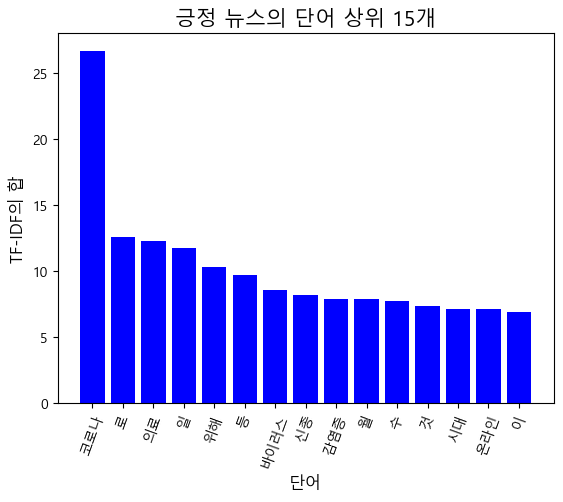

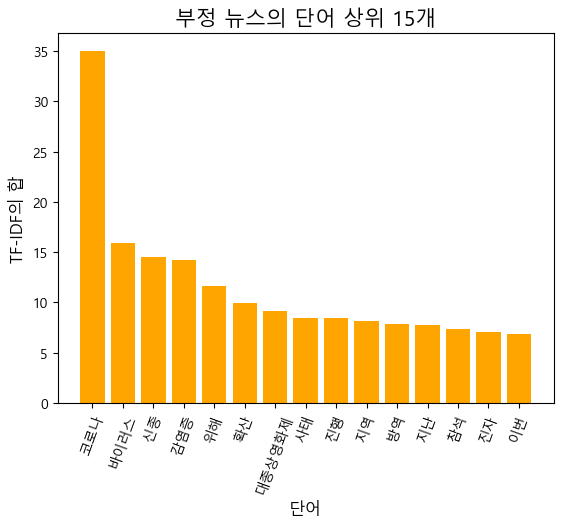

In [92]:
# Step4-1: 이제 진짜 시각화 - 긍정뉴스
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm._get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
max = 15 # 바 차트에 나타낼 단어 수

plt.bar(range(max), [i[1] for i in POS_words[:max]], color='blue')
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)
plt.show()

# Step4-2: 부정뉴스
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color = "orange")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation = 70)
plt.show()


##  Ⅲ. [감성 분석 + 토픽 모델링] 영화 리뷰 데이터로 감성 예측하기

### 1)데이터 준비

In [97]:
# Step1: 토픽 분석에 사용할 데이터는 네이버 뉴스의 전체 description을 사용
# 토픽 모델은 단어별 확률 분포를 분석하므로, 명사를 추출한 단어(토큰) 상태의 리스트를 준비해야 한다!

description2 = data_df['description']
description_noun_tk2 = []
for d in description2:
    description_noun_tk2.append(okt.nouns(d)) # 명사 형태소만 추출

description_noun_tk3 = []
for d in description_noun_tk2:
    item = [i for i in d if len(i)>1] # 1이상인것만
    description_noun_tk3.append(item)

description_noun_tk3 # 길이는 800

800

### 2)분석 모델 구축

In [ ]:
# 토픽 분석을 위한 LDA 모델 구축하기
# ! pip install gensim

In [105]:
import gensim
import gensim.corpora as corpora

## 1. LDA 토픽 모델의 입력 벡터 생성하기

### description_noun_tk2에 포함된 단어에 대해 사전을 구성corpora.Dictionary( )
dictionary = corpora.Dictionary(description_noun_tk3)
dictionary # print해야 값 나옴
print(dictionary) # Dictionary<3580 unique tokens: ['개발', '경제', '국세', '국책', '대응']...>

### 단어 사전dictionary의 단어에 대해 BoW를 구하여doc2bow( ), 단어 뭉치corpus를 구성
    # (word_id, work_count)의 BoW 구성
corpus = [dictionary.doc2bow(word) for word in description_noun_tk3]
print(corpus)

Dictionary<3580 unique tokens: ['개발', '경제', '국세', '국책', '대응']...>
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1)], [(17, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1)], [(5, 1), (17, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(12, 1), (17, 2), (43, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(17, 2), (68, 2), (69, 1), (70, 2), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 2), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)], [(17, 2), (43, 1), (52, 1), (54, 1), (61, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1

In [107]:

## *2. LDA 토픽 모델의 생성 및 훈련하기 - 토픽개수 4개
    # gensim 패키지의 LDA 모듈을 이용하여 토픽 모델 객체인 lda_model을 생성

k = 4 # 토픽의 개수 설정
lda_model = gensim.models.ldamulticore.LdaMulticore(
    corpus, iterations=12, num_topics = k, id2word = dictionary, passes = 1, workers = 10)

### 3)결과 확인 및 시각화

In [108]:
## 1. 분석 결과 확인하기
### 토픽 모델 객체에 저장되어 있는 토픽 분석 결과를 lda_model.print_topics() 함수를 사용하여 출력
'''
- num_words = 15에 따라 토픽을 구성하는 주요 단어 15개가 토픽에 대한 영향력 비율 과 함께 출력된 것을 확인 가능
- 네이버 뉴스를 크롤링할 때 검색어로 ‘코로나’를 사용했기 때문에 모든 토픽에서 ‘코로나’ 단어가 압도적으로 많이 나옴
'''
print(lda_model.print_topics(num_topics = k, num_words = 15))
# K를 4로 두었으니 4개집단으로 나뉠 것
# 만약, k=2면, 2개집단으로 나뉠 것

[(0, '0.064*"코로나" + 0.010*"바이러스" + 0.008*"신종" + 0.008*"위해" + 0.008*"감염증" + 0.005*"지역" + 0.005*"방역" + 0.005*"확산" + 0.004*"시대" + 0.004*"경제" + 0.004*"이번" + 0.004*"사태" + 0.004*"진자" + 0.004*"포스트" + 0.004*"지원"'), (1, '0.052*"코로나" + 0.012*"바이러스" + 0.009*"감염증" + 0.008*"신종" + 0.007*"위해" + 0.006*"이번" + 0.005*"온라인" + 0.005*"확산" + 0.005*"지난" + 0.005*"시대" + 0.004*"진행" + 0.004*"서울" + 0.004*"통해" + 0.004*"의료" + 0.004*"사태"'), (2, '0.060*"코로나" + 0.012*"위해" + 0.008*"바이러스" + 0.007*"신종" + 0.006*"이번" + 0.005*"감염증" + 0.005*"사태" + 0.005*"의료" + 0.005*"방역" + 0.005*"확산" + 0.004*"지역" + 0.004*"어려움" + 0.004*"최근" + 0.003*"예방" + 0.003*"통해"'), (3, '0.070*"코로나" + 0.013*"감염증" + 0.013*"신종" + 0.011*"바이러스" + 0.008*"위해" + 0.008*"확산" + 0.006*"지역" + 0.005*"의료" + 0.004*"사태" + 0.004*"감염" + 0.004*"어려움" + 0.004*"포스트" + 0.004*"진행" + 0.003*"지난" + 0.003*"진자"')]


In [ ]:
## 2. 분석 결과에 대한 정리와 분석을 실시하고, 주요 단어를 고려하여 각 토픽 내용을 설명하는 레이블을 결정
    # ! ppt사진 넣어서 정리하기
    # 여기서 나오는 토.픽.레이블은 내.가. 정하는 거임. 내.가.
        # 각 그룹별로 나뉘어진 '주요단어(최대=num_words)'에서 추출해서 유의미한 주제 결정

# 물론 내.가 정하기 때문에 연구자의 주관적인 의견이 들어가서, 이 분석방법은 항.상 신뢰성에 대한 공격을 받는다
    # 받을 수 밖에 없을 것이고.
    # 그럼에도 불구하고, description같은 내용들로 키워드를 추출해줘서 그룹화를 시켜주는 것은 매우 큰 자엄
    # 빅.데이터의 경우라면 특히 더 그렇겠지
    # *위와 관련해서 LDA의 장점에 대해 더 조사해보기

# 그래서, topic_tracking같은 것도 있음
    # 데이터를 계속 돌려서 topic이 어떻게 변화하는지? 이런 것을

In [ ]:
# ! pip install pyLDAvis

In [110]:
## 3. 분석 결과 시각화하기
    # 토픽 분석 결과를 가지고 있는 lda_model 객체와 단어 뭉치, 단어 사전을 매개변수로 사용

import os
import pyLDAvis.gensim

# 한글 UnicodeEncodeError 방지를 위해 기본 인코딩을 "utf-8"로 설정
os.environ["PYTHONIOENCODING"] = "utf-8"

# LDA 토픽 분석의 결과를 시각화하기 위해 pyLDAvis 패키지의 pyLDAvis.gensim.prepare() 함수를 사용
lda_vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(lda_vis)
'''
- 왼쪽 영역에는 토픽 간 거리 지도가 있고, 오른쪽 영역에는 토픽에서 관련성 높은 30개 단어에 대한 바 차트가 있음
- 왼쪽 영역에 보이는 분포에서 토픽이 포함되어 있거나 많이 겹쳐져 있다면 토픽의 개수 k 값을 다르게 하여 LDA 모델을다시 실행
- 오른쪽 영역 상단에 있는 관련성 메트릭 조정 슬라이드를 움직이면 현재 선택한 토픽에 특화되어 많이 출현하는 단어를확인할 수 있음
- 오른쪽 영역에 있는 단어 위로 마우스를 이동하면 단어의 토픽 영향력에 따라 토픽 버블의 크기가 조정되어 변함
'''

pyLDAvis.save_html(lda_vis, './13장_data/'+file_name+"_vis.html") # pyLDAvis는 웹 브라우저 창에 표시되므로 저장 파일 형식도 html로 설정